In [96]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [97]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [98]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [99]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.3510,0.2891,3800000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.2319,0.4081,3400000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,-0.4378,4.0778,7000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-95.7086,99.3486,65000,BBG01W275XX6
4,AAAU,USD,GOLDMAN SACHS PHYSICAL GOLD,458886642.0,XXXXXXXK1034,3.0333,0.6067,400000,BBG00LPXX872


In [100]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [101]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [102]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [103]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret


def portfolio_returns(long_ret: pd.Series,
                      etf_ret: pd.Series,
                      w_long: float,
                      w_short: float,
                      borrow_annual: float = 0.0,
                      trading_days: int = 252) -> pd.Series:
    """
    Combine long underlying + short ETF (via negative w_short).
    long_ret, etf_ret: daily simple returns of LONG legs (total return)
    w_long:  weight on underlying
    w_short: weight on ETF (negative for short)
    borrow_annual: annualized borrow cost for the ETF (decimal, e.g. 0.37)
    """
    borrow_daily = borrow_annual / trading_days

    df = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if df.empty:
        return pd.Series(dtype=float)

    # Portfolio return including borrow drag
    port_ret = (
        w_long * df["long"] +
        w_short * df["etf"] -
        abs(w_short) * borrow_daily
    )
    port_ret.name = "port_ret"
    return port_ret



def worst_rolling_window(ret_series, window=60):
    """
    Numerically stable worst rolling-window cumulative return.
    ret_series: daily returns in decimal form (0.01 = 1%).
    
    Returns:
        worst_cum_ret: float (e.g. -0.35 for -35%)
        worst_end_date: index label corresponding to the *end* of that window
    """
    # Keep the original index intact
    r = pd.Series(ret_series)

    # If too short, bail
    if r.dropna().shape[0] < window:
        return np.nan, None

    # Safety: if returns look like percentages (5 = 500%), scale them
    # We DON'T want to change the index, only the values.
    if r.abs().max() > 2:  # heuristic threshold
        r = r / 100.0

    # Use log(1+r) for stability
    log_g = np.log1p(r)  # this will propagate NaNs
    # rolling sum of logs, aligning the result to the *right* edge (default)
    roll_log = log_g.rolling(window=window, min_periods=window).sum()

    # Convert back from log-space: exp(sum log) - 1
    roll_cum = np.expm1(roll_log)

    # Drop NaNs (these correspond to windows that weren't full)
    roll_cum_valid = roll_cum.dropna()
    if roll_cum_valid.empty:
        return np.nan, None

    worst = roll_cum_valid.min()
    worst_end_date = roll_cum_valid.idxmin()  # this is the *end* of the window

    return float(worst), worst_end_date


def margin_call_probability(port_ret, margin_level=0.25):
    """
    Simple margin-call metric: equity starts at 1.0,
    margin call if equity < margin_level at any point.
    Returns (probability_over_days, first_call_date).
    """
    equity = (1 + port_ret).cumprod()
    calls = equity < margin_level
    if not calls.any():
        return 0.0, None
    prob = calls.mean()
    first_call_date = equity.index[calls.argmax()]
    return float(prob), first_call_date



In [104]:
import pandas as pd
import yfinance as yf
data = [
    ("2026-01-05", 0.160759),
    ("2025-12-29", 0.162949),
    ("2025-12-22", 0.211471),
    ("2025-12-15", 0.241907),
    ("2025-12-08", 0.248806),
    ("2025-12-01", 0.162049),
    ("2025-11-24", 0.147426),
    ("2025-11-17", 0.232022),
    ("2025-11-10", 0.27678),
    ("2025-11-03", 0.375394),
    ("2025-10-27", 0.358866),
    ("2025-10-20", 0.389369),
    ("2025-10-14", 0.836939),
    ("2025-10-06", 0.438159),
    ("2025-09-29", 0.793874),
    ("2025-09-22", 0.84821),
    ("2025-09-15", 0.51068),
    ("2025-09-08", 0.355776),
    ("2025-09-02", 0.457825),
    ("2025-08-25", 0.40676),
    ("2025-08-18", 1.393529),
    ("2025-08-11", 0.785542),
    ("2025-08-04", 0.856739),
]

df = pd.DataFrame(data, columns=["ex_date", "distribution"])
df["ex_date"] = pd.to_datetime(df["ex_date"])

# -------------------------
# Download price history
# -------------------------
start = df["ex_date"].min() - pd.Timedelta(days=5)
end   = df["ex_date"].max() + pd.Timedelta(days=5)


px = yf.download("MSTW", start=start, end=end, progress=False)

# --- Flatten yfinance output ---
if isinstance(px.columns, pd.MultiIndex):
    # pick the Close column regardless of ticker level order
    if ("Close", "MSTW") in px.columns:
        px = px[("Close", "MSTW")].to_frame("price")
    elif ("Close",) in px.columns:
        px = px["Close"].to_frame("price")
    else:
        # generic: grab first level == "Close"
        px = px.xs("Close", axis=1, level=0)
        # if multiple tickers somehow, take the first column
        if isinstance(px, pd.DataFrame):
            px = px.iloc[:, 0].to_frame("price")
        else:
            px = px.to_frame("price")
else:
    px = px[["Close"]].rename(columns={"Close": "price"})

# reset to column for asof merge
px = px.reset_index().rename(columns={"Date": "price_date"})

# sanity: ensure datetime + sorted
px["price_date"] = pd.to_datetime(px["price_date"])
px = px.sort_values("price_date")
df = df.sort_values("ex_date")

df = pd.merge_asof(df, px, left_on="ex_date", right_on="price_date", direction="backward")
df["weekly_yield"] = df["distribution"] / df["price"]
df

C:\Users\werdn\AppData\Local\Temp\ipykernel_12460\151414267.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download("MSTW", start=start, end=end, progress=False)


,ex_date,distribution,price_date,price,weekly_yield
0,2025-08-04,0.856739,2025-08-04,31.739834,0.026993
1,2025-08-11,0.785542,2025-08-11,32.651997,0.024058
2,2025-08-18,1.393529,2025-08-18,29.216221,0.047697
3,2025-08-25,0.406760,2025-08-25,27.160547,0.014976
4,2025-09-02,0.457825,2025-09-02,26.909069,0.017014
5,2025-09-08,0.355776,2025-09-08,25.777205,0.013802
6,2025-09-15,0.510680,2025-09-15,25.636473,0.019920
7,2025-09-22,0.848210,2025-09-22,26.342436,0.032199
8,2025-09-29,0.793874,2025-09-29,25.363733,0.031300
9,2025-10-06,0.438159,2025-10-06,28.438158,0.015407


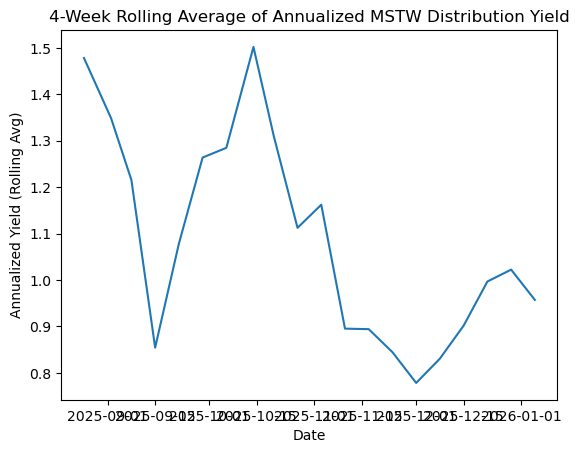

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sorted by date
df = df.sort_values("ex_date").copy()

# Annualize weekly yield
df["annualized_yield"] = df["weekly_yield"] * 52

# Rolling average (choose window)
window = 4   # try 4, 6, or 8
df["annualized_yield_roll"] = df["annualized_yield"].rolling(window).mean()

# Plot
plt.figure()
plt.plot(df["ex_date"], df["annualized_yield_roll"])
plt.xlabel("Date")
plt.ylabel("Annualized Yield (Rolling Avg)")
plt.title(f"{window}-Week Rolling Average of Annualized MSTW Distribution Yield")
plt.show()


In [106]:
import numpy as np

df = df.sort_values("ex_date").copy()

t = np.arange(len(df))          # weekly time index: 0,1,2,...
logp = np.log(df["price"].values)

window = 8  # last 8 weeks
sub = df.tail(window)

t = np.arange(len(sub))
lambda_week = -np.polyfit(t, np.log(sub["price"]), 1)[0]
lambda_annual = lambda_week * 52


print("Weekly decay:", lambda_week)
print("Annualized decay:", lambda_annual)


Weekly decay: 0.03339138863301012
Annualized decay: 1.7363522089165262


In [107]:
P0 = df["price"].iloc[-1]
y_ann = df["annualized_yield_roll"].iloc[-1]
lam = lambda_annual

expected_cash = P0 * y_ann * (1 - np.exp(-lam)) / lam
print("Forward-adjusted expected annual cash:", expected_cash)


Forward-adjusted expected annual cash: 4.827222174021887


In [108]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression

def compute_beta(etf: str, underlying: str, *, start="2024-01-01", end=None, use_adj=True):
    etf = etf.upper().strip()
    underlying = underlying.upper().strip()

    px = yf.download([etf, underlying], start=start, end=end, auto_adjust=False, progress=False)

    # yfinance returns either a MultiIndex column or single columns depending on tickers
    col = "Adj Close" if use_adj else "Close"
    if isinstance(px.columns, pd.MultiIndex):
        if col not in px.columns.get_level_values(0):
            raise ValueError(f"Price column '{col}' not found. Available: {sorted(set(px.columns.get_level_values(0)))}")
        prices = px[col].copy()
    else:
        # single ticker case (shouldn't happen here but be defensive)
        prices = px[[col]].copy()
        prices.columns = [etf]

    # Ensure both tickers exist
    missing = [t for t in [etf, underlying] if t not in prices.columns]
    if missing:
        raise ValueError(f"Missing price series for: {missing}. Columns present: {prices.columns.tolist()}")

    # Compute returns
    ret = prices.pct_change()

    # IMPORTANT: only drop rows where either is missing (pairwise), not entire frame arbitrarily
    pair = ret[[etf, underlying]].dropna(how="any")

    # Diagnostics
    if pair.empty:
        # give helpful debug info
        info = {
            "etf_non_na_prices": int(prices[etf].notna().sum()),
            "und_non_na_prices": int(prices[underlying].notna().sum()),
            "overlap_non_na_rows": int(ret[[etf, underlying]].dropna(how="any").shape[0]),
            "price_date_range": (str(prices.index.min().date()), str(prices.index.max().date())) if len(prices.index) else None,
        }
        raise ValueError(
            f"No overlapping return samples for {etf} vs {underlying}. "
            f"Likely ETF is new or missing data. Diagnostics: {info}"
        )

    X = pair[[underlying]].values  # shape (n,1)
    y = pair[[etf]].values         # shape (n,1)

    model = LinearRegression().fit(X, y)
    beta = float(model.coef_[0][0])
    alpha = float(model.intercept_[0])

    return beta, alpha, pair

# Example
beta, alpha, ret = compute_beta("PLTY", "PLTR", start="2025-01-01")
print("n samples:", len(ret))
print("beta:", beta, "alpha:", alpha)

beta, alpha, ret = compute_beta("GOOY", "GOOGL")
print("Beta (GOOY vs GOOGL):", beta)
print("Alpha:", alpha)

beta, alpha, ret = compute_beta("MSTW", "MSTR")
print("Beta (MSTW vs MSTR):", beta)
print("Alpha:", alpha)


n samples: 255
beta: 0.8058623602241484 alpha: -0.0005624860885084905
Beta (GOOY vs GOOGL): 0.7427521627522821
Alpha: -0.00013432460083471196
Beta (MSTW vs MSTR): 1.1815815839316641
Alpha: -0.0006900925376199206


In [109]:
def portfolio_returns_twolegs_daily_rebalanced(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float = 0.0,
    borrow_b_annual: float = 0.0,
    trading_days: int = 252,
    initial_equity: float = 1.0,
) -> tuple[pd.Series, pd.Series]:
    """
    Explicit daily rebalance:
      - Start of day: set notionals = w_i * equity
      - Apply that day's returns to those notionals
      - Charge borrow on short notionals
      - Update equity
      - Next day: rebalance again

    Returns:
      port_ret: daily equity-to-equity returns
      equity:   daily equity curve
    """
    df = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if df.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    borrow_a_daily = borrow_a_annual / trading_days
    borrow_b_daily = borrow_b_annual / trading_days

    equity = float(initial_equity)
    port_rets = []
    eq_curve = []

    for _, r in df.iterrows():
        notional_a = w_a * equity
        notional_b = w_b * equity

        pnl = notional_a * r["a"] + notional_b * r["b"]

        borrow_cost = 0.0
        if w_a < 0:
            borrow_cost += abs(notional_a) * borrow_a_daily
        if w_b < 0:
            borrow_cost += abs(notional_b) * borrow_b_daily

        equity_next = equity + pnl - borrow_cost
        port_ret = equity_next / equity - 1.0

        port_rets.append(port_ret)
        eq_curve.append(equity_next)
        equity = equity_next

    port_ret_s = pd.Series(port_rets, index=df.index, name="port_ret")
    equity_s   = pd.Series(eq_curve, index=df.index, name="equity")
    return port_ret_s, equity_s


In [110]:

# ============================================================
# Short-vs-Short Levered ETF Pair Research (2x and 3x)
# ============================================================
def portfolio_returns_twolegs(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float = 0.0,
    borrow_b_annual: float = 0.0,
    trading_days: int = 252,
) -> pd.Series:
    """
    Generic 2-leg portfolio return series.

    ret_a, ret_b: daily simple returns of LONG total-return price series
    w_a, w_b: portfolio weights (use negative for shorts)
    borrow_*_annual: annualized borrow cost applied ONLY when the corresponding weight is negative
    """
    df = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if df.empty:
        return pd.Series(dtype=float)

    borrow_a_daily = (borrow_a_annual / trading_days) if w_a < 0 else 0.0
    borrow_b_daily = (borrow_b_annual / trading_days) if w_b < 0 else 0.0

    port = (
        w_a * df["a"] +
        w_b * df["b"] -
        abs(w_a) * borrow_a_daily -
        abs(w_b) * borrow_b_daily
    )
    return port


def simulate_two_leg_monte_carlo(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float,
    borrow_b_annual: float,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    random_state: int | None = None,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    Monte Carlo for a 2-leg portfolio where either or both legs can be short.

    Borrow drag is applied only to legs with negative weight.
    """
    rng = np.random.default_rng(random_state)

    ret_mat = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if ret_mat.shape[0] < 10:
        return None

    if half_life_days is None:
        mu = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        mu = ret_mat.ewm(halflife=half_life_days, adjust=False).mean().iloc[-1].values
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_a_daily = (borrow_a_annual / trading_days) if w_a < 0 else 0.0
    borrow_b_daily = (borrow_b_annual / trading_days) if w_b < 0 else 0.0

    sim_cagrs, sim_dds = [], []
    for _ in range(n_sims):
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_a = sim_daily[:, 0]
        sim_b = sim_daily[:, 1]

        sim_port = (
            w_a * sim_a +
            w_b * sim_b -
            abs(w_a) * borrow_a_daily -
            abs(w_b) * borrow_b_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0

        cum_curve = (1 + sim_port).cumprod()
        peak = np.maximum.accumulate(cum_curve)
        dd = (cum_curve / peak - 1.0).min()

        sim_cagrs.append(cagr)
        sim_dds.append(dd)

    sim_cagrs = np.array(sim_cagrs)
    sim_dds   = np.array(sim_dds)

    return {
        "mc_cagr_p50": np.percentile(sim_cagrs, 50),
        "mc_cagr_p10": np.percentile(sim_cagrs, 10),
        "mc_cagr_p90": np.percentile(sim_cagrs, 90),
        "mc_dd_p50":   np.percentile(sim_dds, 50),
        "mc_dd_p10":   np.percentile(sim_dds, 10),
        "mc_dd_p90":   np.percentile(sim_dds, 90),
    }


def analyze_short_short_pairs_with_mc(
    pairs_df: pd.DataFrame,
    start=None,
    end=None,
    w_a: float = -0.5,
    w_b: float = -0.5,
    margin_level: float = 0.25,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    borrow_map: dict | None = None,
    default_borrow: float = 0.05,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    pairs_df columns: ["LegA","LegB","Leverage","Group"] (Group optional)

    Interprets weights as dollar weights on *long* returns; use negatives for shorts.
    For a symmetric decay trade (e.g., short TQQQ + short SQQQ), defaults to -0.5 / -0.5.
    """
    results = []

    for _, row in pairs_df.iterrows():
        
        a = row["LegA"]
        b = row["LegB"]
        lev = float(row.get("Leverage", np.nan))
        grp = row.get("Group", "")

        print(f"\nProcessing SHORT/SHORT pair: {a} vs {b} (lev={lev}, group={grp})")

        prices_a = get_total_return_series(a, start=start, end=end)
        prices_b = get_total_return_series(b, start=start, end=end)

        if prices_a.empty or prices_b.empty:
            print(" → SKIPPED: missing price data")
            continue

        stats_a, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
        stats_b, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

        if stats_a is None or stats_b is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Borrow (each leg)
        if borrow_map is not None:
            borrow_a = borrow_map.get(a, borrow_map.get("default", default_borrow))
            borrow_b = borrow_map.get(b, borrow_map.get("default", default_borrow))
        else:
            borrow_a = default_borrow
            borrow_b = default_borrow

        port_ret, equity_curve = portfolio_returns_twolegs_daily_rebalanced(
            ret_a, ret_b,
            w_a=w_a, w_b=w_b,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            trading_days=trading_days,
            initial_equity=1.0,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Hist stats (now based on equity curve)
        T = len(equity_curve)
        cumulative = float(equity_curve.iloc[-1])   # equity starts at 1.0
        cagr_port = cumulative ** (trading_days / T) - 1.0
        vol_port  = port_ret.std() * np.sqrt(trading_days)

        # (keep your existing margin call call for now; see note below)
        mc_prob_hist, mc_first_hist = margin_call_probability(port_ret, margin_level=margin_level)

        # MC
        mc_stats = simulate_two_leg_monte_carlo(
            ret_a=ret_a,
            ret_b=ret_b,
            w_a=w_a,
            w_b=w_b,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=half_life_days,
        )

        if mc_stats is None:
            print(" → SKIPPED: MC stats unavailable")
            continue

        results.append({
            "LegA": a,
            "LegB": b,
            "Leverage": lev,
            "Group": grp,
            "w_a": w_a,
            "w_b": w_b,
            "borrow_a": borrow_a,
            "borrow_b": borrow_b,
            "cagr_a": stats_a["cagr"],
            "cagr_b": stats_b["cagr"],
            "vol_a":  stats_a["vol_annual"],
            "vol_b":  stats_b["vol_annual"],
            "cagr_port_hist": cagr_port,
            "vol_port_hist":  vol_port,
            "mc_prob_hist":   mc_prob_hist,
            "mc_first_hist":  mc_first_hist,
            **mc_stats,
        })

    return pd.DataFrame(results)


In [111]:

# --- Simple starter lists of 2x and 3x levered "bull vs bear" pairs ---
# Notes:
# - These are meant to be *same-underlying* leveraged opposites.
# - For the "short/short decay" trade, we short BOTH legs (defaults: -0.5 / -0.5).
pairs_2x = [
    ("SSO",  "SDS",  2, "SPX"),     # S&P 500
    ("QLD",  "QID",  2, "NDX"),     # Nasdaq-100
    ("DDM",  "DXD",  2, "DJIA"),    # Dow
    ("UWM",  "TWM",  2, "RUT"),     # Russell 2000
    ("UCO",  "SCO",  2, "WTI"),     # Crude oil (path-dependent; can be noisy)
    #("TSLT", "TSLZ", 2, "TSLA"),
    ("MSTU", "MSTZ", 2, "MSTR"),
    ("NVDX", "NVDQ", 2, "NVDA"),
    ("BTCL", "BTCZ", 2, "BTC"),
    ("ETU", "ETQ", 2, "ETH"),
    ("CCUP", "CRCD", 2, "CRCL"),
    ("CRWU", "CORD", 2, "CRWV"),
    ("TSLR", "TSLQ", 2, "TSLA") # Lower borrow
]

pairs_3x = [
    ("TQQQ", "SQQQ", 3, "NDX"),
    ("SPXL", "SPXS", 3, "SPX"),
    ("TNA",  "TZA",  3, "RUT"),
    ("SOXL", "SOXS", 3, "SOX"),
    ("FAS",  "FAZ",  3, "FIN"),
    ("LABU", "LABD", 3, "BIOTECH"),
    ("TECL", "TECS", 3, "TECH"),
    ("UDOW", "SDOW", 3, "DJIA"),
]

pairs_shortshort = pd.DataFrame(pairs_2x + pairs_3x, columns=["LegA","LegB","Leverage","Group"])
pairs_shortshort


,LegA,LegB,Leverage,Group
0,SSO,SDS,2,SPX
1,QLD,QID,2,NDX
2,DDM,DXD,2,DJIA
3,UWM,TWM,2,RUT
4,UCO,SCO,2,WTI
5,MSTU,MSTZ,2,MSTR
6,NVDX,NVDQ,2,NVDA
7,BTCL,BTCZ,2,BTC
8,ETU,ETQ,2,ETH
9,CCUP,CRCD,2,CRCL


In [112]:
# adjust column names if yours differ
pair_tickers = sorted(set(pairs_shortshort["LegA"]).union(set(pairs_shortshort["LegB"])))
print("Tickers in pairs:", pair_tickers)

borrow_map_pairs, rebate_map_pairs, available_map_pairs = build_ibkr_short_maps(
    tickers=pair_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map_pairs


Tickers in pairs: ['BTCL', 'BTCZ', 'CCUP', 'CORD', 'CRCD', 'CRWU', 'DDM', 'DXD', 'ETQ', 'ETU', 'FAS', 'FAZ', 'LABD', 'LABU', 'MSTU', 'MSTZ', 'NVDQ', 'NVDX', 'QID', 'QLD', 'SCO', 'SDOW', 'SDS', 'SOXL', 'SOXS', 'SPXL', 'SPXS', 'SQQQ', 'SSO', 'TECL', 'TECS', 'TNA', 'TQQQ', 'TSLQ', 'TSLR', 'TWM', 'TZA', 'UCO', 'UDOW', 'UWM']


{'BTCZ': 0.410148,
 'CCUP': 0.36366,
 'CORD': 2.9202000000000004,
 'CRCD': 0.931712,
 'CRWU': 0.257822,
 'DDM': 0.0025599999999999998,
 'DXD': 0.050567999999999995,
 'ETQ': 1.698674,
 'ETU': 0.026869999999999998,
 'FAS': 0.0,
 'FAZ': 0.196002,
 'LABD': 0.185766,
 'LABU': 0.020806,
 'MSTU': 0.43662999999999996,
 'NVDQ': 0.154454,
 'NVDX': 0.11708400000000001,
 'QID': 0.0,
 'QLD': 0.0,
 'SCO': 0.326354,
 'SDOW': 0.04245,
 'SDS': 0.012681000000000001,
 'SOXL': 0.0,
 'SOXS': 0.0,
 'SPXL': 0.0,
 'SQQQ': 0.0,
 'SSO': 0.0,
 'TECL': 0.0,
 'TECS': 0.154654,
 'TNA': 0.012547999999999998,
 'TQQQ': 0.0,
 'TSLQ': 0.012806,
 'TSLR': 0.024224000000000002,
 'TWM': 0.061186,
 'TZA': 0.09166200000000001,
 'UCO': 0.0,
 'UDOW': 0.031624,
 'UWM': 0.039274,
 'default': 0.05}

In [ ]:

# --- Run the short/short analysis ---
results_shortshort_mc = analyze_short_short_pairs_with_mc(
    pairs_shortshort,
    start=None,
    end=None,
    w_a=-0.5,      # short $0.50 of LegA
    w_b=-0.5,      # short $0.50 of LegB  -> gross short = 1.0
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=1000,
    borrow_map=borrow_map_pairs,
    default_borrow=borrow_map_pairs.get("default", 0.05),
    half_life_days=252,   # optional: more weight on recent history
)



Processing SHORT/SHORT pair: SSO vs SDS (lev=2.0, group=SPX)

Processing SHORT/SHORT pair: QLD vs QID (lev=2.0, group=NDX)

Processing SHORT/SHORT pair: DDM vs DXD (lev=2.0, group=DJIA)

Processing SHORT/SHORT pair: UWM vs TWM (lev=2.0, group=RUT)

Processing SHORT/SHORT pair: UCO vs SCO (lev=2.0, group=WTI)

Processing SHORT/SHORT pair: MSTU vs MSTZ (lev=2.0, group=MSTR)

Processing SHORT/SHORT pair: NVDX vs NVDQ (lev=2.0, group=NVDA)

Processing SHORT/SHORT pair: BTCL vs BTCZ (lev=2.0, group=BTC)

Processing SHORT/SHORT pair: ETU vs ETQ (lev=2.0, group=ETH)

Processing SHORT/SHORT pair: CCUP vs CRCD (lev=2.0, group=CRCL)

Processing SHORT/SHORT pair: CRWU vs CORD (lev=2.0, group=CRWV)

Processing SHORT/SHORT pair: TSLR vs TSLQ (lev=2.0, group=TSLA)

Processing SHORT/SHORT pair: TQQQ vs SQQQ (lev=3.0, group=NDX)

Processing SHORT/SHORT pair: SPXL vs SPXS (lev=3.0, group=SPX)

Processing SHORT/SHORT pair: TNA vs TZA (lev=3.0, group=RUT)

Processing SHORT/SHORT pair: SOXL vs SOXS (lev=

,LegA,LegB,Leverage,Group,w_a,w_b,borrow_a,borrow_b,cagr_a,cagr_b,...,cagr_port_hist,vol_port_hist,mc_prob_hist,mc_first_hist,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
7,BTCL,BTCZ,2.0,BTC,-0.5,-0.5,0.050000,0.410148,0.198225,-0.713388,...,-0.152919,0.031138,0.000000,NaT,0.076100,0.057303,0.096789,-0.029059,-0.041192,-0.021851
15,SOXL,SOXS,3.0,SOX,-0.5,-0.5,0.000000,0.000000,0.329021,-0.679934,...,0.024041,0.034898,0.000000,NaT,0.001583,-0.012974,0.016671,-0.060602,-0.101683,-0.038464
12,TQQQ,SQQQ,3.0,NDX,-0.5,-0.5,0.000000,0.000000,0.422782,-0.527626,...,0.009589,0.012507,0.000000,NaT,-0.017048,-0.021214,-0.012822,-0.085196,-0.103179,-0.065462
1,QLD,QID,2.0,NDX,-0.5,-0.5,0.000000,0.000000,0.246915,-0.347685,...,0.002179,0.014112,0.000000,NaT,-0.025106,-0.027656,-0.022506,-0.119914,-0.131034,-0.107935
0,SSO,SDS,2.0,SPX,-0.5,-0.5,0.000000,0.012681,0.154001,-0.251673,...,-0.008384,0.014021,0.000000,NaT,-0.034382,-0.036755,-0.031940,-0.160662,-0.170762,-0.149951
9,CCUP,CRCD,2.0,CRCL,-0.5,-0.5,0.363660,0.931712,-0.982987,1.328377,...,-0.454837,0.066017,0.000000,NaT,-0.034994,-0.064189,-0.004598,-0.217227,-0.312413,-0.129170
13,SPXL,SPXS,3.0,SPX,-0.5,-0.5,0.000000,0.050000,0.281846,-0.455557,...,-0.013756,0.014260,0.000000,NaT,-0.049534,-0.054943,-0.044094,-0.225625,-0.246721,-0.202632
2,DDM,DXD,2.0,DJIA,-0.5,-0.5,0.002560,0.050568,0.142119,-0.234700,...,-0.026516,0.017177,0.000000,NaT,-0.052535,-0.055594,-0.049378,-0.236556,-0.248626,-0.223756
19,UDOW,SDOW,3.0,DJIA,-0.5,-0.5,0.031624,0.042450,0.264877,-0.384778,...,-0.032800,0.015062,0.000000,NaT,-0.059062,-0.062359,-0.055704,-0.262588,-0.275239,-0.249257
3,UWM,TWM,2.0,RUT,-0.5,-0.5,0.039274,0.061186,0.063561,-0.278393,...,-0.041506,0.018062,0.000000,NaT,-0.070823,-0.075924,-0.065547,-0.307828,-0.326246,-0.287717


In [131]:
results_shortshort_mc.sort_values("mc_cagr_p50", ascending=False)

,LegA,LegB,Leverage,Group,w_a,w_b,borrow_a,borrow_b,cagr_a,cagr_b,...,cagr_port_hist,vol_port_hist,mc_prob_hist,mc_first_hist,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
7,BTCL,BTCZ,2.0,BTC,-0.5,-0.5,0.050000,0.410148,0.198225,-0.713388,...,-0.152919,0.031138,0.000000,NaT,0.076100,0.057303,0.096789,-0.029059,-0.041192,-0.021851
15,SOXL,SOXS,3.0,SOX,-0.5,-0.5,0.000000,0.000000,0.329021,-0.679934,...,0.024041,0.034898,0.000000,NaT,0.001583,-0.012974,0.016671,-0.060602,-0.101683,-0.038464
12,TQQQ,SQQQ,3.0,NDX,-0.5,-0.5,0.000000,0.000000,0.422782,-0.527626,...,0.009589,0.012507,0.000000,NaT,-0.017048,-0.021214,-0.012822,-0.085196,-0.103179,-0.065462
1,QLD,QID,2.0,NDX,-0.5,-0.5,0.000000,0.000000,0.246915,-0.347685,...,0.002179,0.014112,0.000000,NaT,-0.025106,-0.027656,-0.022506,-0.119914,-0.131034,-0.107935
0,SSO,SDS,2.0,SPX,-0.5,-0.5,0.000000,0.012681,0.154001,-0.251673,...,-0.008384,0.014021,0.000000,NaT,-0.034382,-0.036755,-0.031940,-0.160662,-0.170762,-0.149951
9,CCUP,CRCD,2.0,CRCL,-0.5,-0.5,0.363660,0.931712,-0.982987,1.328377,...,-0.454837,0.066017,0.000000,NaT,-0.034994,-0.064189,-0.004598,-0.217227,-0.312413,-0.129170
13,SPXL,SPXS,3.0,SPX,-0.5,-0.5,0.000000,0.050000,0.281846,-0.455557,...,-0.013756,0.014260,0.000000,NaT,-0.049534,-0.054943,-0.044094,-0.225625,-0.246721,-0.202632
2,DDM,DXD,2.0,DJIA,-0.5,-0.5,0.002560,0.050568,0.142119,-0.234700,...,-0.026516,0.017177,0.000000,NaT,-0.052535,-0.055594,-0.049378,-0.236556,-0.248626,-0.223756
19,UDOW,SDOW,3.0,DJIA,-0.5,-0.5,0.031624,0.042450,0.264877,-0.384778,...,-0.032800,0.015062,0.000000,NaT,-0.059062,-0.062359,-0.055704,-0.262588,-0.275239,-0.249257
3,UWM,TWM,2.0,RUT,-0.5,-0.5,0.039274,0.061186,0.063561,-0.278393,...,-0.041506,0.018062,0.000000,NaT,-0.070823,-0.075924,-0.065547,-0.307828,-0.326246,-0.287717


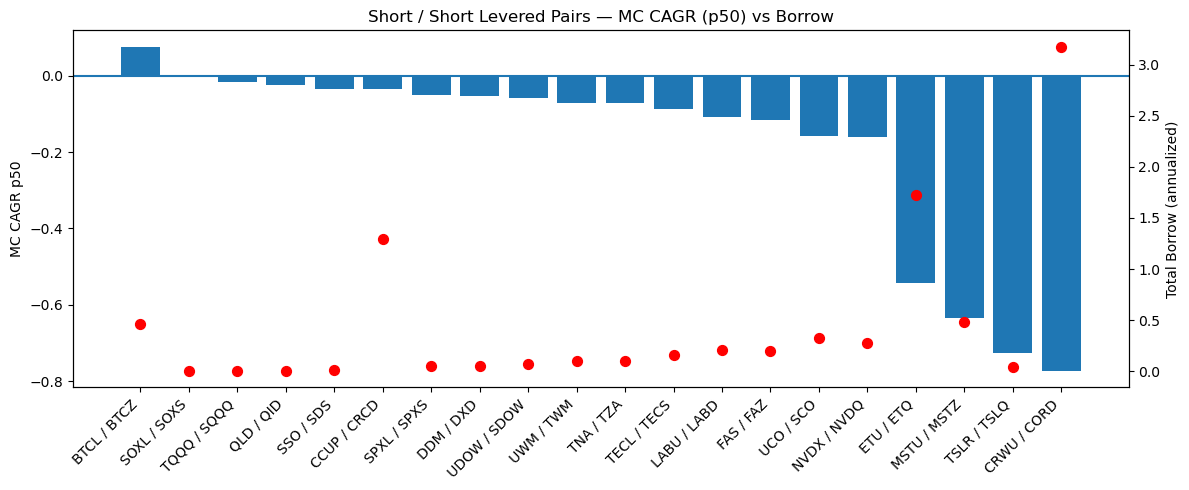

In [114]:
import matplotlib.pyplot as plt
import numpy as np

df = results_shortshort_mc.copy()

# Build labels and total borrow
df["pair"] = df["LegA"] + " / " + df["LegB"]
df["borrow_total"] = df["borrow_a"] + df["borrow_b"]

# Sort: highest CAGR → lowest
df = df.sort_values("mc_cagr_p50", ascending=False).reset_index(drop=True)

x = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Left axis: MC CAGR ---
ax1.bar(x, df["mc_cagr_p50"])
ax1.axhline(0)
ax1.set_ylabel("MC CAGR p50")
ax1.set_xticks(x)
ax1.set_xticklabels(df["pair"], rotation=45, ha="right")

# --- Right axis: Borrow (points only, red) ---
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("Short / Short Levered Pairs — MC CAGR (p50) vs Borrow")
fig.tight_layout()
plt.show()


In [115]:
benchmark_map = {
    "SPX":   "SPY",   # or IVV
    "NDX":   "QQQ",
    "DJIA":  "DIA",
    "RUT":   "IWM",
    "SOX":   "SOXX",  # or SMH
    "FIN":   "XLF",
    "BIOTECH":"XBI",  # or IBB
    "TECH":  "XLK",
    "WTI":   "USO",   # not perfect; futures roll matters
    "TSLA":  "TSLA",
    "MSTR":  "MSTR",
    "NVDA":  "NVDA",
    "BTC":   "IBIT",  # or FBTC; pick one you can source reliably
    "ETH":   "ETHA",  # or similar spot ETH ETF if available in your data source
    "CRCL":  "CRCL",
    "CRWV":  "CRWV",
}


In [116]:
def build_levered_vs_benchmark_pairs_short_short(
    pairs_shortshort: pd.DataFrame,
    benchmark_map: dict,
    base_short: float = -0.5,
    normalize_gross: bool = True,
) -> pd.DataFrame:
    """
    Builds SHORT vs SHORT trades vs the benchmark ETF, but ONLY for the inverse (bear) levered ETFs.
    (i.e., excludes the 2x/3x LONG levered ETFs entirely)

    For each row (Bull, Bear, Leverage L, Group -> benchmark):
      - Short Bear vs Short Benchmark (size benchmark by L)

    Sizing:
      If normalize_gross=True:
        w_lev = -1/(1+L), w_bench = -L/(1+L)   (gross short = 1)
      Else:
        w_lev = base_short, w_bench = base_short * L
    """
    rows = []

    for _, r in pairs_shortshort.iterrows():
        bear = r["LegB"]              # inverse levered ETF
        L    = float(r["Leverage"])
        grp  = r["Group"]

        bench = benchmark_map.get(grp)
        if bench is None:
            continue

        if normalize_gross:
            w_lev   = -1.0 / (1.0 + L)
            w_bench = -L   / (1.0 + L)
        else:
            w_lev   = float(base_short)
            w_bench = float(base_short) * L

        rows.append({
            "LegA": bear,
            "LegB": bench,
            "Leverage": L,
            "Group": grp,
            "w_a": w_lev,
            "w_b": w_bench,
            "Case": "ShortBear_ShortBench"
        })

    return pd.DataFrame(rows)


In [117]:
def analyze_short_short_pairs_with_mc(
    pairs_df: pd.DataFrame,
    start=None,
    end=None,
    w_a: float = -0.5,
    w_b: float = -0.5,
    margin_level: float = 0.25,
    horizon_days: int = 252*5,
    n_sims: int = 1000,
    borrow_map: dict | None = None,
    default_borrow: float = 0.05,
    trading_days: int = 252,
    half_life_days: int | None = None,
):
    """
    Same as the original analyzer, but:
      - reads optional per-row weights w_a / w_b safely
      - does NOT mutate the function arguments across rows
    """
    results = []

    for _, row in pairs_df.iterrows():
        # --- Read weights PER ROW (do not overwrite w_a / w_b) ---
        w_a_eff = float(row["w_a"]) if ("w_a" in row and pd.notna(row["w_a"])) else float(w_a)
        w_b_eff = float(row["w_b"]) if ("w_b" in row and pd.notna(row["w_b"])) else float(w_b)

        a = row["LegA"]
        b = row["LegB"]
        lev = float(row.get("Leverage", np.nan))
        grp = row.get("Group", "")

        print(f"\nProcessing SHORT/SHORT pair: {a} vs {b} (lev={lev}, group={grp}, w=({w_a_eff},{w_b_eff}))")

        prices_a = get_total_return_series(a, start=start, end=end)
        prices_b = get_total_return_series(b, start=start, end=end)

        if prices_a.empty or prices_b.empty:
            print(" → SKIPPED: missing price data")
            continue

        stats_a, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
        stats_b, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

        if stats_a is None or stats_b is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Borrow (each leg)
        if borrow_map is not None:
            borrow_a = borrow_map.get(a, borrow_map.get("default", default_borrow))
            borrow_b = borrow_map.get(b, borrow_map.get("default", default_borrow))
        else:
            borrow_a = default_borrow
            borrow_b = default_borrow

        # Historical path (daily rebalanced equity engine)
        port_ret, equity_curve = portfolio_returns_twolegs_daily_rebalanced(
            ret_a, ret_b,
            w_a=w_a_eff, w_b=w_b_eff,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            trading_days=trading_days,
            initial_equity=1.0,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Hist stats (based on equity curve)
        T = len(equity_curve)
        cumulative = float(equity_curve.iloc[-1])  # equity starts at 1.0
        cagr_port = cumulative ** (trading_days / T) - 1.0
        vol_port  = port_ret.std() * np.sqrt(trading_days)

        mc_prob_hist, mc_first_hist = margin_call_probability(port_ret, margin_level=margin_level)

        # MC (keep your original MC function)
        mc_stats = simulate_two_leg_monte_carlo(
            ret_a=ret_a,
            ret_b=ret_b,
            w_a=w_a_eff,
            w_b=w_b_eff,
            borrow_a_annual=borrow_a,
            borrow_b_annual=borrow_b,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=half_life_days,
        )

        if mc_stats is None:
            print(" → SKIPPED: MC stats unavailable")
            continue

        results.append({
            "LegA": a,
            "LegB": b,
            "Leverage": lev,
            "Group": grp,
            "w_a": w_a_eff,
            "w_b": w_b_eff,
            "borrow_a": borrow_a,
            "borrow_b": borrow_b,
            "cagr_a": stats_a["cagr"],
            "cagr_b": stats_b["cagr"],
            "vol_a":  stats_a["vol_annual"],
            "vol_b":  stats_b["vol_annual"],
            "cagr_port_hist": cagr_port,
            "vol_port_hist":  vol_port,
            "mc_prob_hist":   mc_prob_hist,
            "mc_first_hist":  mc_first_hist,
            **mc_stats,
        })

    return pd.DataFrame(results)


In [137]:
pairs_lev_vs_bench = build_levered_vs_benchmark_pairs_short_short(
    pairs_shortshort,
    benchmark_map=benchmark_map,
    base_short=-0.5,
    normalize_gross=True,   # keeps gross = 1; set False for true delta hedge notionals
)

# IMPORTANT: rebuild borrow map to include bench tickers too
all_tickers = sorted(set(pairs_lev_vs_bench["LegA"]).union(set(pairs_lev_vs_bench["LegB"])))
borrow_map_pairs, rebate_map_pairs, available_map_pairs = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)
# --- Manual borrow overrides ---
borrow_map_pairs["BTCZ"] = 0.225   # 22.5%
borrow_map_pairs["MSTW"] = 0.035   # 3.5%
borrow_map_pairs["BTCL"] = 0.0375
borrow_map_pairs["BITU"] = 0.0

# Add custom pair: short MSTZ vs short MSTW (1/2 to 1)
custom_row = pd.DataFrame([{
    "LegA": "MSTZ",
    "LegB": "MSTW",
    "Leverage": 2,            # informational; set what you want
    "Group": "MSTZ_MSTW",       # label for grouping
    "w_a": -0.333,              # short MSTZ
    "w_b": -0.667,              # short MSTW
    "Case": "ShortMSTZ_ShortMSTW_0.5_1.0"
}])

custom_row_2 = pd.DataFrame([{
    "LegA": "BTCZ",
    "LegB": "MSTW",
    "Leverage": 2,            # informational; set what you want
    "Group": "BTCZ_MSTW",       # label for grouping
    "w_a": -0.333,              # short MSTZ
    "w_b": -0.667,              # short MSTW
    "Case": "ShortBTCZ_ShortMSTW_0.5_1.0"
}])

pairs_lev_vs_bench = pd.concat([pairs_lev_vs_bench, custom_row, custom_row_2], ignore_index=True)

pairs_lev_vs_bench

,LegA,LegB,Leverage,Group,w_a,w_b,Case
0,SDS,SPY,2.0,SPX,-0.333333,-0.666667,ShortBear_ShortBench
1,QID,QQQ,2.0,NDX,-0.333333,-0.666667,ShortBear_ShortBench
2,DXD,DIA,2.0,DJIA,-0.333333,-0.666667,ShortBear_ShortBench
3,TWM,IWM,2.0,RUT,-0.333333,-0.666667,ShortBear_ShortBench
4,SCO,USO,2.0,WTI,-0.333333,-0.666667,ShortBear_ShortBench
5,MSTZ,MSTR,2.0,MSTR,-0.333333,-0.666667,ShortBear_ShortBench
6,NVDQ,NVDA,2.0,NVDA,-0.333333,-0.666667,ShortBear_ShortBench
7,BTCZ,IBIT,2.0,BTC,-0.333333,-0.666667,ShortBear_ShortBench
8,ETQ,ETHA,2.0,ETH,-0.333333,-0.666667,ShortBear_ShortBench
9,CRCD,CRCL,2.0,CRCL,-0.333333,-0.666667,ShortBear_ShortBench


In [119]:

results_lev_vs_bench = analyze_short_short_pairs_with_mc(
    pairs_lev_vs_bench,
    w_a=-0.5, w_b=-0.5,  # ignored when row weights exist
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=500,
    borrow_map=borrow_map_pairs,
    default_borrow=borrow_map_pairs.get("default", 0.05),
    half_life_days=252,
)

results_lev_vs_bench.sort_values("mc_cagr_p50", ascending=False).head(20)



Processing SHORT/SHORT pair: SDS vs SPY (lev=2.0, group=SPX, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: QID vs QQQ (lev=2.0, group=NDX, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: DXD vs DIA (lev=2.0, group=DJIA, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: TWM vs IWM (lev=2.0, group=RUT, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: SCO vs USO (lev=2.0, group=WTI, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: MSTZ vs MSTR (lev=2.0, group=MSTR, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: NVDQ vs NVDA (lev=2.0, group=NVDA, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: BTCZ vs IBIT (lev=2.0, group=BTC, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pair: ETQ vs ETHA (lev=2.0, group=ETH, w=(-0.3333333333333333,-0.6666666666666666))

Processing SHORT/SHORT pai

,LegA,LegB,Leverage,Group,w_a,w_b,borrow_a,borrow_b,cagr_a,cagr_b,...,cagr_port_hist,vol_port_hist,mc_prob_hist,mc_first_hist,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
21,BTCZ,MSTW,2.0,BTCZ_MSTW,-0.333000,-0.667000,0.225000,0.035000,-0.713388,-0.931338,...,2.029287,0.293270,0.000000,NaT,2.294357,1.897179,2.685551,-0.103061,-0.138612,-0.082473
20,MSTZ,MSTW,2.0,MSTZ_MSTW,-0.333000,-0.667000,0.050000,0.035000,-0.929483,-0.931338,...,0.358440,0.082005,0.000000,NaT,0.831476,0.758654,0.899601,-0.020088,-0.026335,-0.016286
5,MSTZ,MSTR,2.0,MSTR,-0.333333,-0.666667,0.050000,0.000000,-0.929483,0.103080,...,0.012738,0.025261,0.000000,NaT,0.014220,0.003210,0.025567,-0.029257,-0.048086,-0.020671
15,SOXS,SOXX,3.0,SOX,-0.250000,-0.750000,0.000000,0.000000,-0.679934,0.121624,...,-0.002599,0.014572,0.000000,NaT,-0.031190,-0.036782,-0.025343,-0.148836,-0.172978,-0.122576
1,QID,QQQ,2.0,NDX,-0.333333,-0.666667,0.000000,0.000000,-0.347685,0.105059,...,-0.009271,0.014002,0.000000,NaT,-0.035898,-0.038142,-0.033555,-0.167203,-0.176702,-0.156830
12,SQQQ,QQQ,3.0,NDX,-0.250000,-0.750000,0.000000,0.000000,-0.527626,0.105059,...,-0.008320,0.008023,0.000000,NaT,-0.036257,-0.039085,-0.033345,-0.168845,-0.180857,-0.156373
0,SDS,SPY,2.0,SPX,-0.333333,-0.666667,0.012681,0.000000,-0.251673,0.107334,...,-0.016583,0.011680,0.000000,NaT,-0.042531,-0.046235,-0.038850,-0.195919,-0.210798,-0.179746
19,SDOW,DIA,3.0,DJIA,-0.250000,-0.750000,0.042450,0.000000,-0.384778,0.090702,...,-0.020600,0.006302,0.000000,NaT,-0.048854,-0.050711,-0.046970,-0.221483,-0.228963,-0.213643
13,SPXS,SPY,3.0,SPX,-0.250000,-0.750000,0.050000,0.000000,-0.455557,0.107334,...,-0.018935,0.009451,0.000000,NaT,-0.052153,-0.056894,-0.047252,-0.235753,-0.253912,-0.215502
2,DXD,DIA,2.0,DJIA,-0.333333,-0.666667,0.050568,0.000000,-0.234700,0.090702,...,-0.027977,0.012642,0.000000,NaT,-0.053440,-0.055523,-0.051323,-0.240153,-0.248263,-0.231634


In [120]:
# Export to CSV
results_lev_vs_bench.to_csv(
    "results_lev_vs_bench.csv",
    index=False
)

print("Saved results_lev_vs_bench.csv")


Saved results_lev_vs_bench.csv


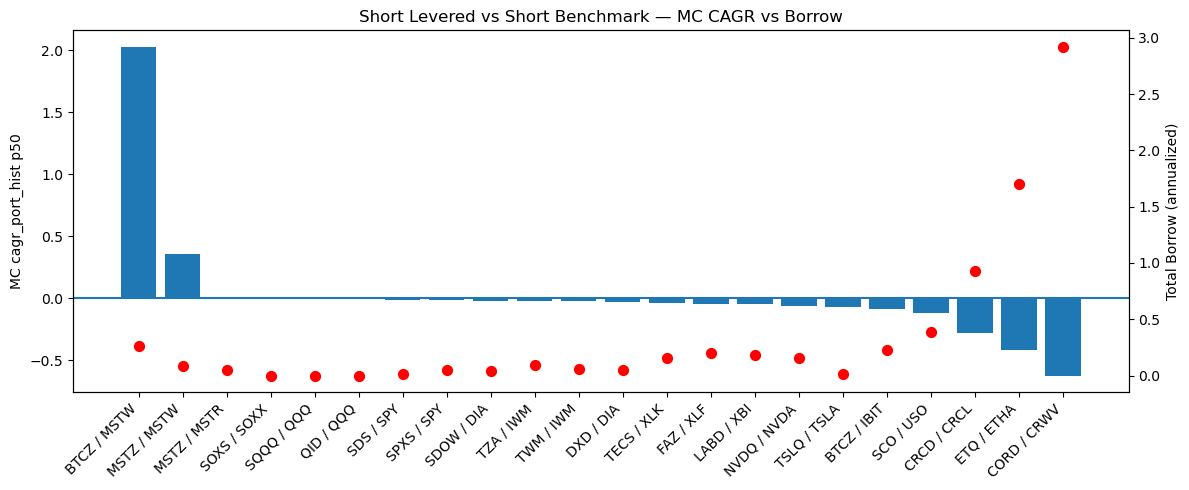

In [121]:
import matplotlib.pyplot as plt
import numpy as np

df = results_lev_vs_bench.copy()

df["pair"] = df["LegA"] + " / " + df["LegB"]
df["borrow_total"] = df["borrow_a"] + df["borrow_b"]

# Sort highest → lowest CAGR
df = df.sort_values("cagr_port_hist", ascending=False).reset_index(drop=True)

x = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(12, 5))

# --- Left axis: MC CAGR ---
ax1.bar(x, df["cagr_port_hist"])
ax1.axhline(0)
ax1.set_ylabel("MC cagr_port_hist p50")
ax1.set_xticks(x)
ax1.set_xticklabels(df["pair"], rotation=45, ha="right")

# --- Right axis: Borrow (red dots only) ---
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("Short Levered vs Short Benchmark — MC CAGR vs Borrow")
fig.tight_layout()
plt.show()


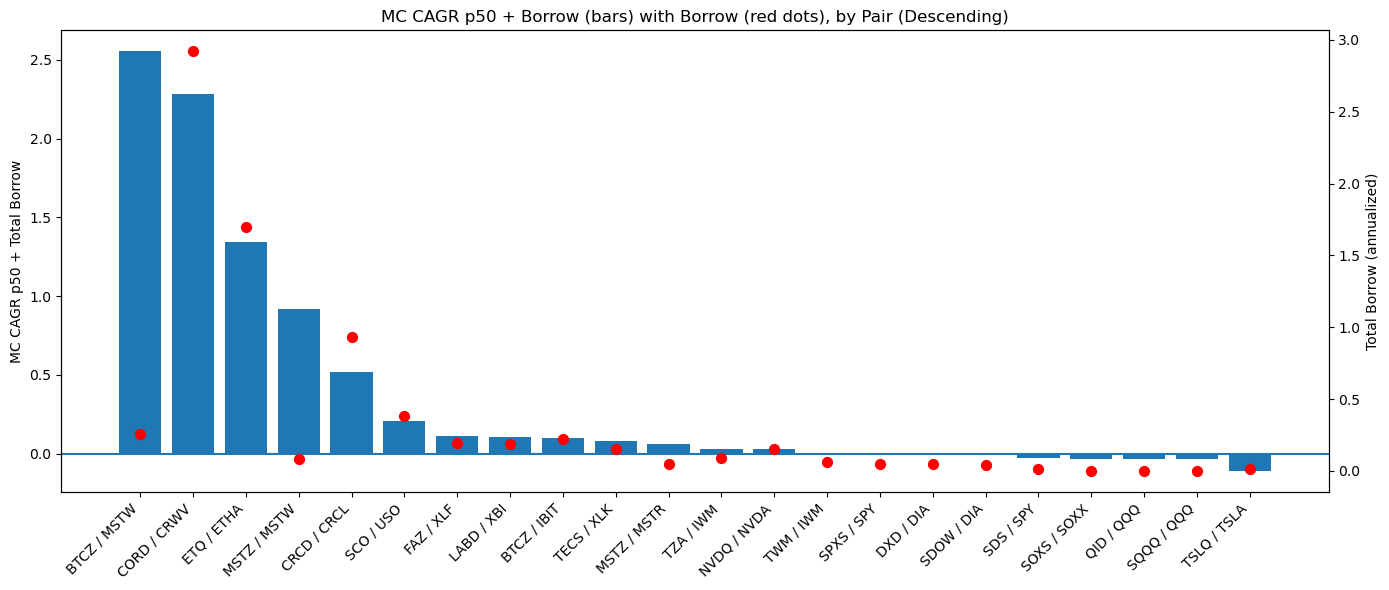

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = results_lev_vs_bench.copy()

# Pair label + total borrow
df["pair"] = df["LegA"].astype(str) + " / " + df["LegB"].astype(str)
df["borrow_total"] = (
    pd.to_numeric(df["borrow_a"], errors="coerce").fillna(0.0)
  + pd.to_numeric(df["borrow_b"], errors="coerce").fillna(0.0)
)

# Ensure numeric CAGR
df["mc_cagr_p50"] = pd.to_numeric(df["mc_cagr_p50"], errors="coerce")

# Metric to rank/plot (per your request)
df["cagr_plus_borrow"] = df["mc_cagr_p50"] + df["borrow_total"]

# Drop missing + sort descending
df_plot = (
    df.dropna(subset=["cagr_plus_borrow", "borrow_total"])
      .sort_values("cagr_plus_borrow", ascending=False)
      .reset_index(drop=True)
)

x = np.arange(len(df_plot))

# ---- One consolidated figure ----
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bars: CAGR + Borrow
ax1.bar(x, df_plot["cagr_plus_borrow"])
ax1.axhline(0)
ax1.set_ylabel("MC CAGR p50 + Total Borrow")

ax1.set_xticks(x)
ax1.set_xticklabels(df_plot["pair"], rotation=45, ha="right")

# Dots: Borrow (right axis)
ax2 = ax1.twinx()
ax2.scatter(
    x,
    df_plot["borrow_total"],
    color="red",
    s=50,
    zorder=3
)
ax2.set_ylabel("Total Borrow (annualized)")

plt.title("MC CAGR p50 + Borrow (bars) with Borrow (red dots), by Pair (Descending)")
fig.tight_layout()
plt.show()


ETQ / ETHA | Case: ShortBear_ShortBench
weights: w_a=-0.333333, w_b=-0.666667
borrow:  ETQ=169.8674%, ETHA=0.0000%
Hist CAGR: -0.42283652193766796
Mean CAGR: -0.35475269134515175
P10: -0.36180879805431715
P50: -0.35489561207777937
P90: -0.34749405725483723


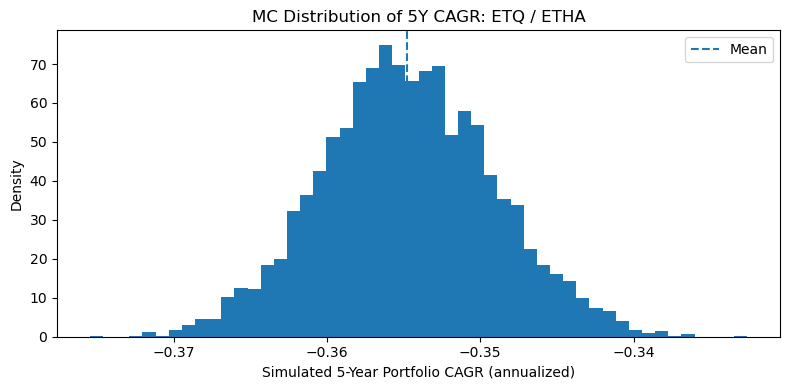

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Choose the pair you want to inspect
# -----------------------------
legA = "ETQ"
legB = "ETHA"   # or whatever your benchmark / other leg is

pair_to_view = pairs_lev_vs_bench[
    (pairs_lev_vs_bench["LegA"] == legA) &
    (pairs_lev_vs_bench["LegB"] == legB)
].iloc[0]

print(pair_to_view["LegA"], "/", pair_to_view["LegB"], "| Case:", pair_to_view.get("Case", ""))

# -----------------------------
# Pull weights + borrow
# -----------------------------
w_a = float(pair_to_view["w_a"]) if ("w_a" in pair_to_view and pd.notna(pair_to_view["w_a"])) else -0.5
w_b = float(pair_to_view["w_b"]) if ("w_b" in pair_to_view and pd.notna(pair_to_view["w_b"])) else -0.5

# Borrow map used in your batch run
borrow_a = float(borrow_map_pairs.get(legA, borrow_map_pairs.get("default", 0.05)))
borrow_b = float(borrow_map_pairs.get(legB, borrow_map_pairs.get("default", 0.05)))

print(f"weights: w_a={w_a:.6f}, w_b={w_b:.6f}")
print(f"borrow:  {legA}={borrow_a:.4%}, {legB}={borrow_b:.4%}")

# -----------------------------
# Load TR series and compute daily returns (same as batch)
# -----------------------------
trading_days = 252
prices_a = get_total_return_series(legA, start=None, end=None)
prices_b = get_total_return_series(legB, start=None, end=None)

_, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
_, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

# -----------------------------
# Historical daily-rebalanced path (for sanity)
# -----------------------------
port_ret_hist, equity_hist = portfolio_returns_twolegs_daily_rebalanced(
    ret_a, ret_b,
    w_a=w_a, w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    trading_days=trading_days,
    initial_equity=1.0,
)

T = len(equity_hist)
cagr_hist = float(equity_hist.iloc[-1]) ** (trading_days / T) - 1.0
print("Hist CAGR:", cagr_hist)

# -----------------------------
# Monte Carlo with the NEW consistent engine
# -----------------------------
horizon_days = 252 * 5
n_sims = 5000

# -----------------------------
# If you want the FULL distribution (like your old sim_cagrs), add this helper
# -----------------------------
def simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float,
    borrow_b_annual: float,
    horizon_days: int,
    n_sims: int,
    random_state: int | None,
    trading_days: int = 252,
    half_life_days: int | None = None,
    initial_equity: float = 1.0,
):
    rng = np.random.default_rng(random_state)
    ret_mat = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if ret_mat.shape[0] < 10:
        return np.array([])

    if half_life_days is None:
        mu = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        mu = ret_mat.ewm(halflife=half_life_days, adjust=False).mean().iloc[-1].values
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_a_daily = borrow_a_annual / trading_days
    borrow_b_daily = borrow_b_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)

        equity = float(initial_equity)
        for t in range(horizon_days):
            rA, rB = sim_daily[t, 0], sim_daily[t, 1]
            notional_a = w_a * equity
            notional_b = w_b * equity

            pnl = notional_a * rA + notional_b * rB

            borrow_cost = 0.0
            if w_a < 0:
                borrow_cost += abs(notional_a) * borrow_a_daily
            if w_b < 0:
                borrow_cost += abs(notional_b) * borrow_b_daily

            equity = equity + pnl - borrow_cost
            if equity <= 0:
                equity = 0.0
                break

        # If it blew up, treat as -100% CAGR (or skip); here we include as -100%
        if equity <= 0:
            sim_cagrs.append(-1.0)
        else:
            cumulative = equity / initial_equity
            cagr = cumulative ** (trading_days / horizon_days) - 1.0
            sim_cagrs.append(cagr)

    return np.array(sim_cagrs)

sim_cagrs = simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a=ret_a,
    ret_b=ret_b,
    w_a=w_a,
    w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
    half_life_days=252,
    initial_equity=1.0,
)

print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50:", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR (annualized)")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {legA} / {legB}")
plt.legend()
plt.tight_layout()
plt.show()


BTCZ / MSTW | Case: ShortBTCZ_ShortMSTW_0.5_1.0
weights: w_a=-0.366300, w_b=-0.667000
borrow:  BTCZ=22.5000%, MSTW=3.5000%
Hist CAGR: 1.9081437680858815
Mean CAGR: 1.6171299167444042
P10: 1.3062524899454646
P50: 1.6017134371516815
P90: 1.94687825257218


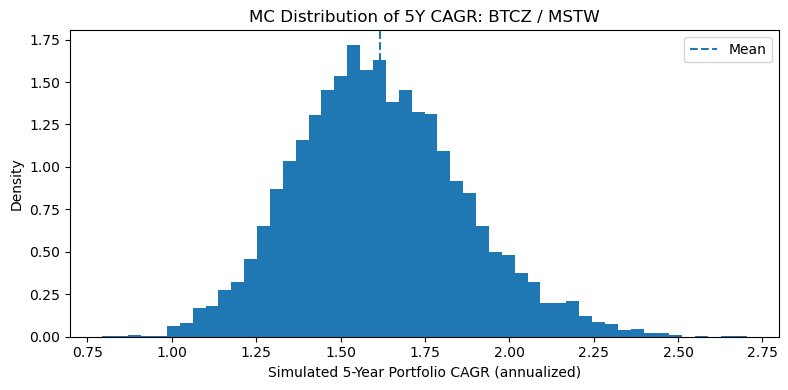

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Choose the pair you want to inspect
# -----------------------------
legA = "BTCZ"
legB = "MSTW"   # or whatever your benchmark / other leg is

pair_to_view = pairs_lev_vs_bench[
    (pairs_lev_vs_bench["LegA"] == legA) &
    (pairs_lev_vs_bench["LegB"] == legB)
].iloc[0]

print(pair_to_view["LegA"], "/", pair_to_view["LegB"], "| Case:", pair_to_view.get("Case", ""))

# -----------------------------
# Pull weights + borrow
# -----------------------------
w_a = float(pair_to_view["w_a"])*1.1 if ("w_a" in pair_to_view and pd.notna(pair_to_view["w_a"])) else -0.5
w_b = float(pair_to_view["w_b"]) if ("w_b" in pair_to_view and pd.notna(pair_to_view["w_b"])) else -0.5

# Borrow map used in your batch run
borrow_a = float(borrow_map_pairs.get(legA, borrow_map_pairs.get("default", 0.05)))
borrow_b = float(borrow_map_pairs.get(legB, borrow_map_pairs.get("default", 0.05)))

print(f"weights: w_a={w_a:.6f}, w_b={w_b:.6f}")
print(f"borrow:  {legA}={borrow_a:.4%}, {legB}={borrow_b:.4%}")

# -----------------------------
# Load TR series and compute daily returns (same as batch)
# -----------------------------
trading_days = 252
prices_a = get_total_return_series(legA, start=None, end=None)
prices_b = get_total_return_series(legB, start=None, end=None)

_, ret_a = compute_leg_stats(prices_a, trading_days=trading_days)
_, ret_b = compute_leg_stats(prices_b, trading_days=trading_days)

# -----------------------------
# Historical daily-rebalanced path (for sanity)
# -----------------------------
port_ret_hist, equity_hist = portfolio_returns_twolegs_daily_rebalanced(
    ret_a, ret_b,
    w_a=w_a, w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    trading_days=trading_days,
    initial_equity=1.0,
)

T = len(equity_hist)
cagr_hist = float(equity_hist.iloc[-1]) ** (trading_days / T) - 1.0
print("Hist CAGR:", cagr_hist)

# -----------------------------
# Monte Carlo with the NEW consistent engine
# -----------------------------
horizon_days = 252 * 5
n_sims = 5000

# -----------------------------
# If you want the FULL distribution (like your old sim_cagrs), add this helper
# -----------------------------
def simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a: pd.Series,
    ret_b: pd.Series,
    w_a: float,
    w_b: float,
    borrow_a_annual: float,
    borrow_b_annual: float,
    horizon_days: int,
    n_sims: int,
    random_state: int | None,
    trading_days: int = 252,
    half_life_days: int | None = None,
    initial_equity: float = 1.0,
):
    rng = np.random.default_rng(random_state)
    ret_mat = pd.concat([ret_a.rename("a"), ret_b.rename("b")], axis=1).dropna()
    if ret_mat.shape[0] < 10:
        return np.array([])

    if half_life_days is None:
        mu = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        mu = ret_mat.ewm(halflife=half_life_days, adjust=False).mean().iloc[-1].values
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_a_daily = borrow_a_annual / trading_days
    borrow_b_daily = borrow_b_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)

        equity = float(initial_equity)
        for t in range(horizon_days):
            rA, rB = sim_daily[t, 0], sim_daily[t, 1]
            notional_a = w_a * equity
            notional_b = w_b * equity

            pnl = notional_a * rA + notional_b * rB

            borrow_cost = 0.0
            if w_a < 0:
                borrow_cost += abs(notional_a) * borrow_a_daily
            if w_b < 0:
                borrow_cost += abs(notional_b) * borrow_b_daily

            equity = equity + pnl - borrow_cost
            if equity <= 0:
                equity = 0.0
                break

        # If it blew up, treat as -100% CAGR (or skip); here we include as -100%
        if equity <= 0:
            sim_cagrs.append(-1.0)
        else:
            cumulative = equity / initial_equity
            cagr = cumulative ** (trading_days / horizon_days) - 1.0
            sim_cagrs.append(cagr)

    return np.array(sim_cagrs)

sim_cagrs = simulate_two_leg_monte_carlo_rebalanced_full(
    ret_a=ret_a,
    ret_b=ret_b,
    w_a=w_a,
    w_b=w_b,
    borrow_a_annual=borrow_a,
    borrow_b_annual=borrow_b,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
    half_life_days=252,
    initial_equity=1.0,
)

print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50:", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR (annualized)")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {legA} / {legB}")
plt.legend()
plt.tight_layout()
plt.show()


In [147]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

# ------------------------------------------------------------
# 1) Beta estimation to BTC
# ------------------------------------------------------------
def beta_to_btc(asset_ret: pd.Series, btc_ret: pd.Series, min_obs: int = 60) -> float:
    df = pd.concat([asset_ret.rename("asset"), btc_ret.rename("btc")], axis=1).dropna()
    if len(df) < min_obs:
        return np.nan
    x = df["btc"].to_numpy()
    y = df["asset"].to_numpy()
    vx = np.var(x, ddof=1)
    if vx <= 0:
        return np.nan
    return float(np.cov(y, x, ddof=1)[0, 1] / vx)

def estimate_betas_to_btc(ret_df: pd.DataFrame, btc_col: str = "BTC", min_obs: int = 60) -> dict:
    betas = {}
    btc = ret_df[btc_col]
    for c in ret_df.columns:
        if c == btc_col:
            continue
        betas[c] = beta_to_btc(ret_df[c], btc, min_obs=min_obs)
    return betas


# ------------------------------------------------------------
# 2) Rebalanced portfolio backtest with borrow on shorts
# ------------------------------------------------------------
def portfolio_returns_rebalanced(
    ret_df: pd.DataFrame,          # daily returns, columns = symbols
    weights: dict,                 # target weights (notionals = weight * equity at rebalance)
    borrow_annual: dict,           # annual borrow rate by symbol (only charged if position < 0)
    trading_days: int = TRADING_DAYS,
    initial_equity: float = 1.0,
    rebalance: str = "daily",      # "daily","weekly","monthly","quarterly","never"
    rebalance_days: int | None = None,
):
    w = pd.Series(weights, dtype=float)
    ret_df = ret_df[w.index].dropna()

    if rebalance_days is None:
        mapping = {"daily": 1, "weekly": 5, "monthly": 21, "quarterly": 63, "never": 10**9}
        if rebalance not in mapping:
            raise ValueError(f"Unknown rebalance='{rebalance}'")
        rebalance_days = mapping[rebalance]

    borrow_daily = {k: float(v) / trading_days for k, v in borrow_annual.items()}

    equity = float(initial_equity)
    equity_path = []
    port_ret_path = []

    notionals = {sym: 0.0 for sym in w.index}

    def do_rebalance():
        # notionals are set from CURRENT equity at rebalance time
        for sym, wi in w.items():
            notionals[sym] = float(wi) * equity

    do_rebalance()
    prev_equity = equity

    for t, (dt, row) in enumerate(ret_df.iterrows()):
        # rebalance at START of day
        if t > 0 and (t % rebalance_days == 0):
            do_rebalance()

        pnl = 0.0
        borrow_cost = 0.0

        for sym in w.index:
            r = float(row[sym])
            notional = float(notionals[sym])

            pnl += notional * r

            # charge borrow if actually short
            if notional < 0:
                borrow_cost += abs(notional) * borrow_daily.get(sym, 0.0)

        equity = equity + pnl - borrow_cost

        if equity <= 0:
            equity = 0.0
            equity_path.append(equity)
            port_ret_path.append(-1.0)
            break

        equity_path.append(equity)
        port_ret_path.append(equity / prev_equity - 1.0)
        prev_equity = equity

    equity_series = pd.Series(equity_path, index=ret_df.index[:len(equity_path)], name="equity")
    port_ret = pd.Series(port_ret_path, index=ret_df.index[:len(port_ret_path)], name="port_ret").fillna(0.0)
    return port_ret, equity_series


# ------------------------------------------------------------
# 3) Stats (CAGR computed generally)
# ------------------------------------------------------------
def compute_stats(port_ret: pd.Series, equity: pd.Series, trading_days: int = TRADING_DAYS):
    if equity is None or len(equity) < 10:
        return None

    # Use ratio so it works even if initial_equity != 1
    start = float(equity.iloc[0])
    end = float(equity.iloc[-1])
    if start <= 0:
        return None

    T = len(equity)
    cagr = (end / start) ** (trading_days / T) - 1.0

    vol = float(port_ret.std(ddof=1) * np.sqrt(trading_days))
    denom = (port_ret.std(ddof=1) * np.sqrt(trading_days) + 1e-12)
    sharpe = float((port_ret.mean() * trading_days) / denom)

    roll_max = equity.cummax()
    maxdd = float((equity / roll_max - 1.0).min())

    return {"CAGR": float(cagr), "Vol": vol, "Sharpe": sharpe, "MaxDD": maxdd}


# ------------------------------------------------------------
# 4) Generic grid search with net-beta-to-BTC neutrality
#    - grid searches all legs except 1 "hedge_leg"
#    - solves hedge_leg weight to force net beta ~= 0
# ------------------------------------------------------------
def grid_search_beta_neutral(
    ret_df_all: pd.DataFrame,      # must include btc_col + all legs
    longs: list[str],
    shorts: list[str],
    btc_col: str,
    betas: dict,                   # beta per symbol (NOT including BTC)
    borrow_annual: dict,
    grid_long=(0.2, 2.0, 0.2),     # (min, max, step) for each long weight (positive)
    grid_short=(0.2, 2.0, 0.2),    # (min, max, step) for each short abs-weight (positive; actual weight negative)
    hedge_leg: str | None = None,  # which single leg gets solved for neutrality
    gross_cap: float = 3.0,
    rebalance: str = "daily",
    min_obs_beta: int = 60,
    net_beta_tol: float = 1e-10,   # construction tolerance
    realized_beta_check: bool = True,
):
    legs = list(longs) + list(shorts)

    # choose hedge leg
    if hedge_leg is None:
        # default: first short if available, else last long
        hedge_leg = shorts[0] if len(shorts) else longs[-1]
    if hedge_leg not in legs:
        raise ValueError(f"hedge_leg='{hedge_leg}' must be in longs+shorts")

    # align returns
    needed_cols = [btc_col] + legs
    missing = [c for c in needed_cols if c not in ret_df_all.columns]
    if missing:
        raise ValueError(f"ret_df_all missing columns: {missing}")

    ret_df = ret_df_all[needed_cols].dropna()
    btc_series = ret_df[btc_col]
    ret_legs = ret_df[legs]

    # validate betas
    for sym in legs:
        b = betas.get(sym, np.nan)
        if not np.isfinite(b):
            raise ValueError(f"Missing/invalid beta for {sym}: {b}")

    b_hedge = float(betas[hedge_leg])
    if abs(b_hedge) < 1e-12:
        raise ValueError(f"hedge_leg '{hedge_leg}' beta ~ 0; can't solve neutrality.")

    # build grids
    minL, maxL, stepL = grid_long
    minS, maxS, stepS = grid_short
    long_grid = np.arange(minL, maxL + 1e-12, stepL)
    short_grid = np.arange(minS, maxS + 1e-12, stepS)

    # which legs are free vs solved
    free_longs = [x for x in longs if x != hedge_leg]
    free_shorts = [x for x in shorts if x != hedge_leg]
    free_legs = free_longs + free_shorts

    # create per-leg grids (same range for all longs, same for all shorts)
    per_leg_vals = {}
    for sym in free_legs:
        if sym in longs:
            per_leg_vals[sym] = long_grid
        else:
            per_leg_vals[sym] = short_grid  # abs weights; sign applied later

    # recursive grid iterator (keeps it general for any number of legs)
    results = []

    def rec_build(idx: int, w_partial: dict):
        if idx == len(free_legs):
            # solve hedge leg to make net beta = 0
            net_wo_hedge = 0.0
            for sym, w in w_partial.items():
                net_wo_hedge += float(w) * float(betas[sym])
            w_hedge = -net_wo_hedge / b_hedge

            weights = dict(w_partial)
            weights[hedge_leg] = float(w_hedge)

            # enforce sign convention:
            #   longs should be >= 0, shorts should be <= 0
            for sym in longs:
                if sym in weights and weights[sym] < 0:
                    return
            for sym in shorts:
                if sym in weights and weights[sym] > 0:
                    return

            gross = sum(abs(float(v)) for v in weights.values())
            if gross > gross_cap:
                return

            net_beta = sum(float(weights[sym]) * float(betas[sym]) for sym in legs)
            if abs(net_beta) > net_beta_tol:
                return

            port_ret, equity = portfolio_returns_rebalanced(
                ret_df=ret_legs,
                weights=weights,
                borrow_annual=borrow_annual,
                trading_days=TRADING_DAYS,
                initial_equity=1.0,
                rebalance=rebalance,
            )
            stats = compute_stats(port_ret, equity, trading_days=TRADING_DAYS)
            if stats is None:
                return

            realized_beta = np.nan
            if realized_beta_check:
                realized_beta = beta_to_btc(port_ret, btc_series.loc[port_ret.index], min_obs=min_obs_beta)

            results.append({
                **{f"w_{k}": float(v) for k, v in weights.items()},
                "Gross": float(gross),
                "NetBeta_Constr": float(net_beta),
                "Beta_to_BTC_realized": float(realized_beta) if np.isfinite(realized_beta) else np.nan,
                "Rebalance": rebalance,
                **stats,
            })
            return

        sym = free_legs[idx]
        vals = per_leg_vals[sym]

        if sym in longs:
            # positive
            for v in vals:
                w_partial[sym] = float(v)
                rec_build(idx + 1, w_partial)
        else:
            # shorts are negative
            for v in vals:
                w_partial[sym] = -float(v)
                rec_build(idx + 1, w_partial)

        w_partial.pop(sym, None)

    rec_build(0, {})
    return pd.DataFrame(results)


# ------------------------------------------------------------
# Example usage with your pipeline:
# - You provide get_total_return_series + compute_leg_stats
# - Build ret_mat with BTC + assets
# - Estimate betas
# - Run grid search
# ------------------------------------------------------------

longs  = ["MSTR", "IBIT"]
shorts = ["BITU"]
btc_proxy = "BTC"  # or "IBIT"

def get_daily_returns(sym: str) -> pd.Series:
    px = get_total_return_series(sym, start=None, end=None)
    _, ret = compute_leg_stats(px, trading_days=TRADING_DAYS)
    return ret

rets = {s: get_daily_returns(s) for s in (longs + shorts)}
ret_btc = get_daily_returns(btc_proxy)

ret_mat = pd.concat(
    [ret_btc.rename("BTC")] + [rets[s].rename(s) for s in longs + shorts],
    axis=1
).dropna()

betas = estimate_betas_to_btc(ret_mat, btc_col="BTC", min_obs=60)
borrow = {s: float(borrow_map_pairs.get(s, borrow_map_pairs.get("default", 0.05))) for s in (longs + shorts)}
print(betas)
print(borrow)
df_res = grid_search_beta_neutral(
    ret_df_all=ret_mat,
    longs=longs,
    shorts=shorts,
    btc_col="BTC",
    betas=betas,
    borrow_annual=borrow,
    grid_long=(0.1, 3.0, 0.1),
    grid_short=(0.1, 3.0, 0.1),
    hedge_leg=None,          # defaults to first short
    gross_cap=3.0,
    rebalance="monthly",
)
df_res.sort_values(["Sharpe", "CAGR"], ascending=False).head(20)


{'MSTR': 1.349933190448642, 'IBIT': 1.0016019550519144, 'BITU': 1.998189716203501}
{'MSTR': 0.0, 'IBIT': 0.0, 'BITU': 0.0}


,w_MSTR,w_IBIT,w_BITU,Gross,NetBeta_Constr,Beta_to_BTC_realized,Rebalance,CAGR,Vol,Sharpe,MaxDD
17,0.1,1.8,-0.969816,2.869816,0.0,0.000017,monthly,0.150145,0.061491,2.286749,-0.021781
16,0.1,1.7,-0.919691,2.719691,0.0,0.000018,monthly,0.141267,0.061021,2.176457,-0.022429
15,0.1,1.6,-0.869565,2.569565,0.0,0.000018,monthly,0.132451,0.060570,2.063772,-0.023076
14,0.1,1.5,-0.819440,2.419440,0.0,0.000019,monthly,0.123697,0.060137,1.948728,-0.023724
13,0.1,1.4,-0.769314,2.269314,0.0,0.000019,monthly,0.115005,0.059723,1.831368,-0.024371
12,0.1,1.3,-0.719189,2.119189,0.0,0.000019,monthly,0.106374,0.059329,1.711742,-0.025019
11,0.1,1.2,-0.669063,1.969063,0.0,0.000020,monthly,0.097804,0.058955,1.589913,-0.026989
10,0.1,1.1,-0.618938,1.818938,0.0,0.000020,monthly,0.089294,0.058601,1.465952,-0.029953
9,0.1,1.0,-0.568812,1.668812,0.0,0.000020,monthly,0.080845,0.058267,1.339941,-0.032909
8,0.1,0.9,-0.518687,1.518687,0.0,0.000020,monthly,0.072455,0.057955,1.211970,-0.036399


In [148]:
# Now you can rank WITHOUT beta penalty, because construction is neutral.
# But keep realized Beta_to_BTC visible (it will drift more when rebalance is slower).
top_by_freq = (
    df_res
        .sort_values(["CAGR"], ascending=False)
        .head(10)
)
top_by_freq


,w_MSTR,w_IBIT,w_BITU,Gross,NetBeta_Constr,Beta_to_BTC_realized,Rebalance,CAGR,Vol,Sharpe,MaxDD
17,0.1,1.8,-0.969816,2.869816,0.0,0.000017,monthly,0.150145,0.061491,2.286749,-0.021781
16,0.1,1.7,-0.919691,2.719691,0.0,0.000018,monthly,0.141267,0.061021,2.176457,-0.022429
34,0.2,1.7,-0.987249,2.887249,0.0,0.000070,monthly,0.138547,0.114863,1.162635,-0.075942
15,0.1,1.6,-0.869565,2.569565,0.0,0.000018,monthly,0.132451,0.060570,2.063772,-0.023076
33,0.2,1.6,-0.937123,2.737123,0.0,0.000070,monthly,0.129753,0.114599,1.097169,-0.080008
50,0.3,1.6,-1.004681,2.904681,0.0,0.000133,monthly,0.124942,0.169223,0.753914,-0.148933
14,0.1,1.5,-0.819440,2.419440,0.0,0.000019,monthly,0.123697,0.060137,1.948728,-0.023724
32,0.2,1.5,-0.886998,2.586998,0.0,0.000070,monthly,0.121021,0.114345,1.031268,-0.084058
49,0.3,1.5,-0.954555,2.754555,0.0,0.000132,monthly,0.116245,0.169048,0.708465,-0.152711
13,0.1,1.4,-0.769314,2.269314,0.0,0.000019,monthly,0.115005,0.059723,1.831368,-0.024371


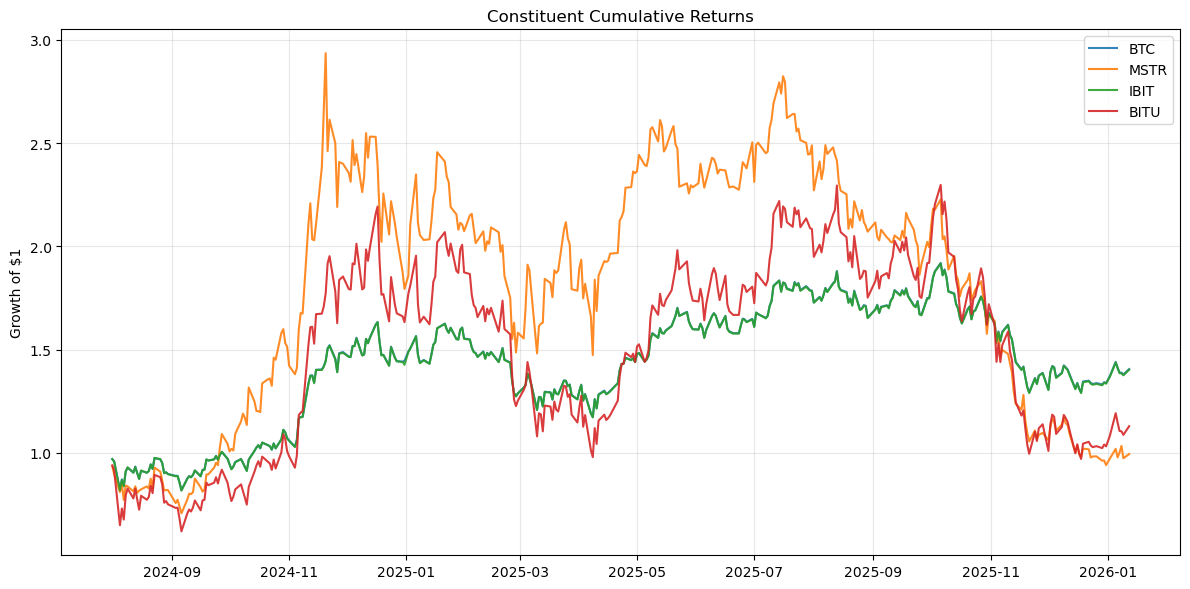

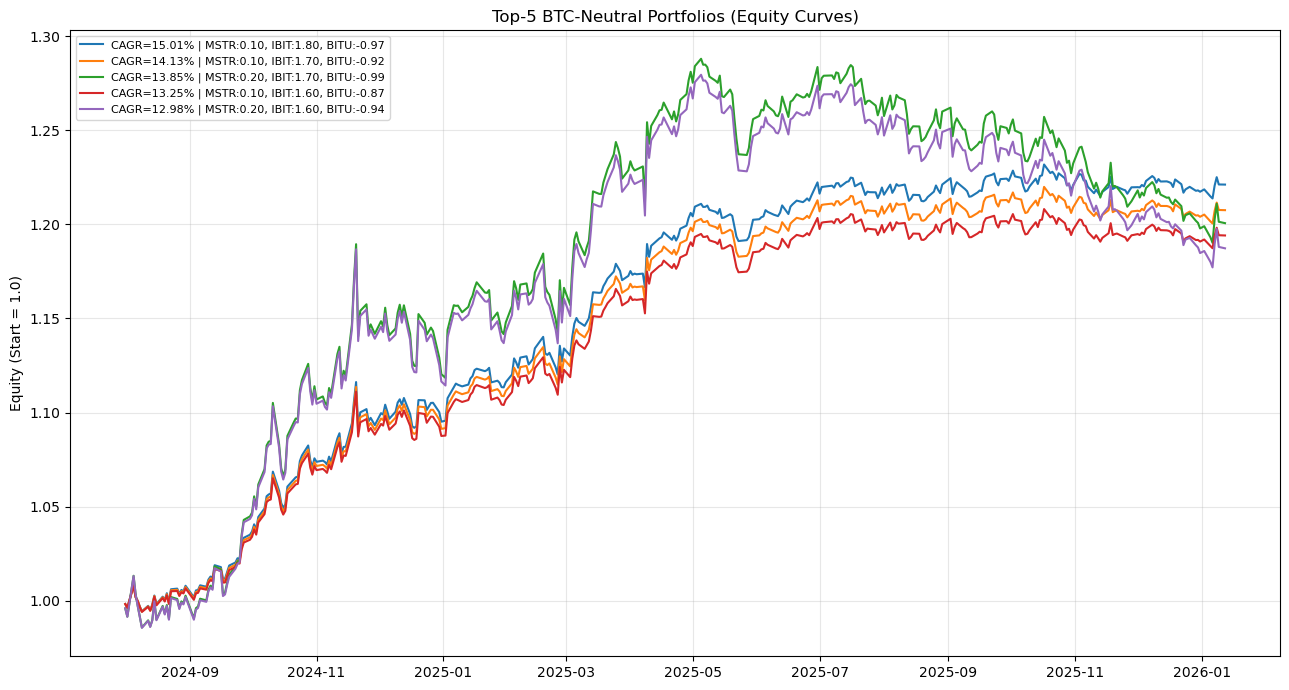

In [151]:
import matplotlib.pyplot as plt

def cum_returns(ret: pd.Series, start: float = 1.0) -> pd.Series:
    return start * (1 + ret.fillna(0)).cumprod()

def plot_constituents(ret_mat: pd.DataFrame):
    plt.figure(figsize=(12, 6))

    for col in ret_mat.columns:
        cr = cum_returns(ret_mat[col])
        plt.plot(cr.index, cr.values, label=col, alpha=0.9)

    plt.title("Constituent Cumulative Returns")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

top5 = (
    df_res
        .sort_values("CAGR", ascending=False)
        .head(5)
        .reset_index(drop=True)
)

def run_portfolio_from_row(row, ret_legs, borrow, rebalance):
    weights = {
        k.replace("w_", ""): row[k]
        for k in row.index
        if k.startswith("w_")
    }

    _, equity = portfolio_returns_rebalanced(
        ret_df=ret_legs,
        weights=weights,
        borrow_annual=borrow,
        trading_days=TRADING_DAYS,
        initial_equity=1.0,
        rebalance=rebalance,
    )
    return equity


def plot_top_portfolios(top_df, ret_mat, borrow):
    ret_legs = ret_mat[[c for c in ret_mat.columns]]

    plt.figure(figsize=(13, 7))

    for i, row in top_df.iterrows():
        equity = run_portfolio_from_row(
            row,
            ret_legs=ret_legs,
            borrow=borrow,
            rebalance=row["Rebalance"],
        )

        label = (
            f"CAGR={row['CAGR']:.2%} | "
            + ", ".join(
                f"{k.replace('w_', '')}:{row[k]:.2f}"
                for k in row.index if k.startswith("w_")
            )
        )

        plt.plot(equity.index, equity.values, label=label)

    plt.title("Top-5 BTC-Neutral Portfolios (Equity Curves)")
    plt.ylabel("Equity (Start = 1.0)")
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_constituents(ret_mat)

plot_top_portfolios(top5, ret_mat, borrow)


In [129]:
data = [
    ("2026-01-05", 0.160759),
    ("2025-12-29", 0.162949),
    ("2025-12-22", 0.211471),
    ("2025-12-15", 0.241907),
    ("2025-12-08", 0.248806),
    ("2025-12-01", 0.162049),
    ("2025-11-24", 0.147426),
    ("2025-11-17", 0.232022),
    ("2025-11-10", 0.27678),
    ("2025-11-03", 0.375394),
    ("2025-10-27", 0.358866),
    ("2025-10-20", 0.389369),
    ("2025-10-14", 0.836939),
    ("2025-10-06", 0.438159),
    ("2025-09-29", 0.793874),
    ("2025-09-22", 0.84821),
    ("2025-09-15", 0.51068),
    ("2025-09-08", 0.355776),
    ("2025-09-02", 0.457825),
    ("2025-08-25", 0.40676),
    ("2025-08-18", 1.393529),
    ("2025-08-11", 0.785542),
    ("2025-08-04", 0.856739),
]
data

[('2026-01-05', 0.160759),
 ('2025-12-29', 0.162949),
 ('2025-12-22', 0.211471),
 ('2025-12-15', 0.241907),
 ('2025-12-08', 0.248806),
 ('2025-12-01', 0.162049),
 ('2025-11-24', 0.147426),
 ('2025-11-17', 0.232022),
 ('2025-11-10', 0.27678),
 ('2025-11-03', 0.375394),
 ('2025-10-27', 0.358866),
 ('2025-10-20', 0.389369),
 ('2025-10-14', 0.836939),
 ('2025-10-06', 0.438159),
 ('2025-09-29', 0.793874),
 ('2025-09-22', 0.84821),
 ('2025-09-15', 0.51068),
 ('2025-09-08', 0.355776),
 ('2025-09-02', 0.457825),
 ('2025-08-25', 0.40676),
 ('2025-08-18', 1.393529),
 ('2025-08-11', 0.785542),
 ('2025-08-04', 0.856739)]

In [130]:
ticker = "MSTW"
t = yf.Ticker(ticker)

df = t.history(period='max', auto_adjust=False, actions=True)

close = df["Close"]
divs = df.get("Dividends", pd.Series(0.0, index=df.index))
divs = divs.reindex(close.index, fill_value=0.0)
rel = (close + divs) / close.shift(1)
rel.iloc[0] = 1.0

tr_price = close.iloc[0] * rel.cumprod()
tr_price.name = ticker + "_TR"
